loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
Dataset info loaded.

Image file: COCO_val2014_000000003103.jpg


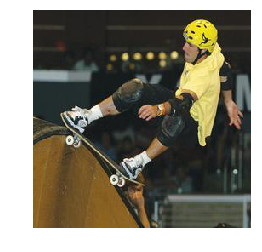

Caption generated by Original model:
<start> a man on a skateboard riding down the street . <end>

Caption generated by GAN model:
<start> a man on a skateboard is riding down the ramp . <end>


Captions written by humans:
1. A man riding a skateboard up the side of a wooden ramp.
2. A man is grinding a ramp on a skateboard
3. Man riding on edge of an oval ramp with a skate board.
4. A man in a helmet skateboarding before an audience.
5. A man on a skateboard is doing a trick.

Image file: COCO_val2014_000000000661.jpg


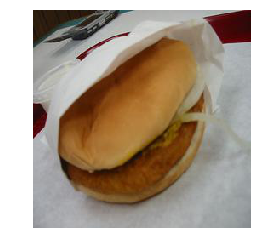

Caption generated by Original model:
<start> a hot dog with a pickle and cheese on it . <end>

Caption generated by GAN model:
<start> a chicken sandwich with a pickle in it . <end>


Captions written by humans:
1. A chicken sandwich in a wrapper near a cell phone.
2. A fast food sandwich half wrapped in a wrapper.
3. A sandwich that is in paper on a table.
4. A table with a chicken sandwich and a cellphone.
5. A sandwich in a wrapper  on a table. 

Image file: COCO_val2014_000000000999.jpg


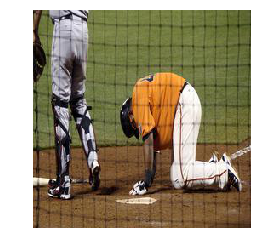

Caption generated by Original model:
<start> a baseball player is swinging a bat at a ball <end>

Caption generated by GAN model:
<start> a baseball player in orange shirt is knealing on the field <end>


Captions written by humans:
1. A young man kneeling on top of a base.
2. baseball player kneeling on ground near home plate
3. a man in a baseball uniform resting on his knees on the baseball field
4. A baseball player on home plate on his knees.
5. baseball player knealing on the field in orange shirt

Image file: COCO_val2014_000000002894.jpg


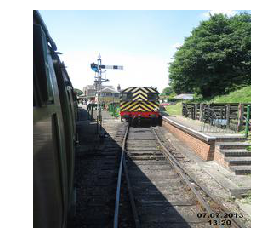

Caption generated by Original model:
<start> a train is going down the tracks in a city . <end>

Caption generated by GAN model:
<start> a train is traveling down the train track in a city . <end>


Captions written by humans:
1. A train traveling down train tracks next to trees.
2. A train traveling down train tracks during the day.
3. A train on the tracks at a train station 
4. Two trains on tracks very close to each other.
5. the back of a train going down the tracks.

Image file: COCO_val2014_000000003595.jpg


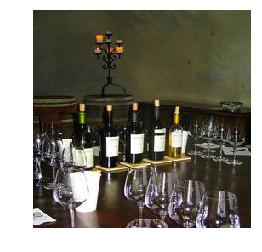

Caption generated by Original model:
<start> a table with a bunch of wine glasses on it <end>

Caption generated by GAN model:
<start> a table with a bunch of wine glasses on it <end>


Captions written by humans:
1. A table with wine glasses and bottles of wine
2. There are bottles of wine and wine glasses arranged on a table
3. THERE ARE A LOT OF WINE GLASSES ON THE TABLE 
4. A selection of wines and wineglasses sit on a table.
5. Six bottles have been placed near many wine glasses.

Image file: COCO_val2014_000000000599.jpg


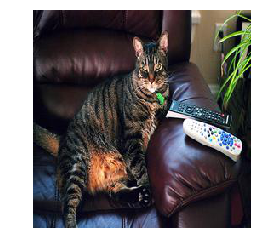

Caption generated by Original model:
<start> a cat laying on top of a red chair . <end>

Caption generated by GAN model:
<start> a cat is sitting on top of a leather chair . <end>


Captions written by humans:
1. A cat on a leather chair next to remotes
2. A cat sitting on a couch with two remote controls. 
3. A cat sitting on top of a brown leather chair.
4. A cat is sitting on a leather couch next to two remotes. 
5. A cat sitting in the chair with two remotes on the arm of the chair.

Image file: COCO_val2014_000000003711.jpg


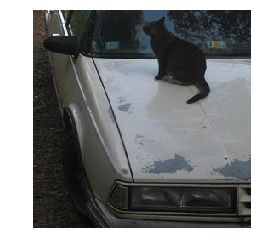

Caption generated by Original model:
<start> a cat sitting on top of a car seat . <end>

Caption generated by GAN model:
<start> a cat is sitting on top of a car hood . <end>


Captions written by humans:
1. A black cat sitting on top of the hood of a car.
2. a cat sitting on the hood of a car that needs a paint job
3. A cat sits on the hood of an old car.
4. There is something that looks particularly interesting here. 

5. A black cat sitting on a hood of an old car

Image file: COCO_val2014_000000004498.jpg


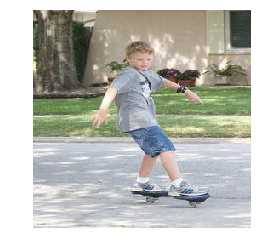

Caption generated by Original model:
<start> a young man is riding a skateboard on the sidewalk . <end>

Caption generated by GAN model:
<start> a young man is riding a skateboard on the street . <end>


Captions written by humans:
1. A young boy riding a skateboard on a street in front of a house.
2. A young boy riding a twisty skateboard down the street
3. Small child in grey shirt riding on top of a small skateboard.
4. A young boy is riding on a two wheeled skateboard.
5. A young boy skateboarding on a suburban street

Image file: COCO_val2014_000000000715.jpg


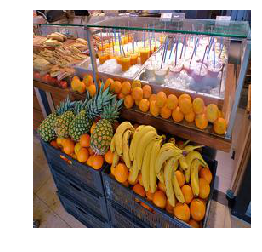

Caption generated by Original model:
<start> a display of oranges and apples in a market . <end>

Caption generated by GAN model:
<start> a pile of oranges and apples are in crates . <end>


Captions written by humans:
1. A pile of oranges in crates topped with yellow bananas.
2. There are bananas, pineapples, oranges, sandwiches, and drinks at the stand.
3. Pineapples, bananas and oranges are in crates near smoothies.
4. A bunch of different fruits sitting in baskets and on a table. 
5. Smoothies in plastic cups lined up in a glass container and a black crate full of oranges, bananas and pineapple. 

Image file: COCO_val2014_000000001436.jpg


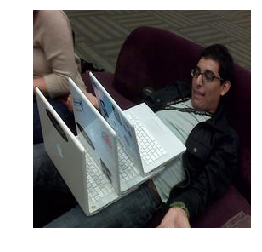

Caption generated by Original model:
<start> a man sitting on a couch with a laptop computer . <end>

Caption generated by GAN model:
<start> a man is sitting on a couch with white laptop computers . <end>


Captions written by humans:
1. Young man wearing glasses lounging on a sofa with three white laptop computers on his lap.
2. A young man lieing down with three apple computers on his chest.
3. A man has three laptops stacked on his knees on the couch. 
4. A man relaxes with three laptops on his lap.
5. A man sits lies on a couch with 3 laptop computers stacked on him.



In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torch.autograd import Variable 
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN, DecoderRNN_tf
from PIL import Image
import glob
from pycocotools.coco import COCO

def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image
    
def main(args):
    
    cap = COCO( 'data/annotations/captions_val2014.json')
    ids = cap.getImgIds()
    print 'Dataset info loaded.'
    print ''

    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)
        
    with open( 'captions.txt', 'r') as f:
        captions = f.readlines()

    # Build Models
    encoder = EncoderCNN(args.embed_size)
    encoder.eval()  # evaluation mode (BN uses moving mean/variance)
    decoder = DecoderRNN_tf(args.embed_size, args.hidden_size, 
                         len(vocab), args.num_layers)
    
    encoder_gan = EncoderCNN(args.embed_size)
    encoder_gan.eval()  # evaluation mode (BN uses moving mean/variance)
    decoder_gan = DecoderRNN(args.embed_size, args.hidden_size, 
                         len(vocab), args.num_layers, 1 )
    
    
    # Load Teacher Forcing model
    encoder.load_state_dict( torch.load(args.encoder_path) )
    decoder.load_state_dict( torch.load(args.decoder_path) )
    
    encoder_gan.load_state_dict( torch.load( args.encoder_gan_path ) )
    decoder_gan.load_state_dict( torch.load( args.decoder_gan_path ) )
    
    # Load GAN model
    
    # Load images
    images = glob.glob( args.images + '*.jpg' )[:10]

    # Prepare Image
    for i, image_path in enumerate( images ):
        
        file_name = image_path.split('/')[-1]
        image = load_image( image_path , transform)
        image_tensor = to_var( image, volatile=True )
        
        idx = 0
        for id in ids:
            if file_name == cap.imgs[id]['file_name']:
                idx = id
                break
        
        Real_captions = [ item['caption'] for item in cap.imgToAnns[ idx ] ]

        # If use gpu
        if torch.cuda.is_available():
            encoder.cuda()
            decoder.cuda()

        # Generate caption from image
        feature = encoder( image_tensor )
        sampled_ids = decoder.sample( feature )
        sampled_ids = sampled_ids.cpu().data.numpy()

        # Decode word_ids to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            sampled_caption.append(word)
            if word == '<end>':
                break
        sentence = ' '.join(sampled_caption)
        
        # Generate captions based on GAN model
        feature = encoder( image_tensor )
        sampled_ids = decoder.sample( feature )
        sampled_ids = sampled_ids.cpu().data.numpy()

        # Decode word_ids to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            sampled_caption.append(word)
            if word == '<end>':
                break
        sentence2 = ' '.join(sampled_caption)

        
        print 'Image file:', file_name
        
        image = Image.open( image_path )
        plt.imshow(np.asarray(image))
        plt.axis('off')
        plt.show()
        
        
        # Print out image and generated caption.
        print 'Caption generated by Original model:'
        print sentence
        print ''
        
        print 'Caption generated by GAN model:'
        print captions[i]
        print ''
        
        
        print 'Captions written by humans:'
        for idx, caption in enumerate( Real_captions ):
            print str(idx+1)+'.', caption
            
        print ''
         
    
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument( '-f', default='self', help='To make it runnable in jupyter' )
    parser.add_argument('--images', type=str, default='./demo/',
                        help='input image path for generating caption')
    parser.add_argument('--encoder_path', type=str, default='./models-Teacher Forcing alone/encoder-5-3000.pkl',
                        help='path for trained encoder')
    parser.add_argument('--decoder_path', type=str, default='./models-Teacher Forcing alone/decoder-5-3000.pkl',
                        help='path for trained decoder')
    
    parser.add_argument('--encoder_gan_path', type=str, default='./models/Adversarial-encoder-2-3000.pkl',
                        help='path for trained gan encoder')
    parser.add_argument('--decoder_gan_path', type=str, default='./models/Adversarial-decoder-2-3000.pkl',
                        help='path for trained gan decoder')
    
    parser.add_argument('--vocab_path', type=str, default='./data/vocab.pkl',
                        help='path for vocabulary wrapper')
    
    # Model parameters (should be same as paramters in train.py)
    parser.add_argument('--embed_size', type=int , default=256,
                        help='dimension of word embedding vectors')
    parser.add_argument('--hidden_size', type=int , default=512,
                        help='dimension of lstm hidden states')
    parser.add_argument('--num_layers', type=int , default=1 ,
                        help='number of layers in lstm')
    args = parser.parse_args()
    main(args)